### 예측 정산 제도 정산금 지급 기준
- 거래일 전날 10시와 17시, 2회에 걸쳐 거래일의 발전량 예측치를 제출
- 각 회차별 오차율(NAE, Normalized Absolute Error): (|실제 발전량 - 발전량 예측량| / 설비용량) * 100
- 각 회차의 시간대별 이용가능 발전의 오차율을 평균하여, 예측제도 정산금 지급에 사용되는 평균 오차율을 계산
    - 이용가능 발전: 이용율이 10% 이상인 시간대의 발전량
        - 이용율: 발전량 / 설비용량 * 100
    - 이용가능 발전의 오차율: (|실제 발전량 - 발전량 예측량| / 설비용량) * 100 if 이용률 <= 8% else NaN
    - 평균 오차율(NMAE, Normalized Mean Absolute Error): MEAN(1회차 이용가능 발전의 오차율, 2회차 이용가능 발전의 오차율)
- 예측제도 정산금은 평균 오차율이 **기준 오차율**(8%) 이하시, 발전량에 정산금 단가 반영하여 지급
    - 정산금 단가: 계통운영 상 비용절감 총편익 / 태양광 발전량
        - 평균 오차율 8% 이하: 3원/kWh
        - 평균 오차율 6% 이하: 4원/kWh
    - 예측제도 정산금 지급금액: Σ 발전량(kWh) * 정산금 단가(원/kWh)

> NOTE: 전력시장운영규칙 전문, 제14장 재생에너지 발전량 예측제도 참고<br>
> (소수점 처리 관련 별표 8 참고)

In [1]:
import sys
from collections import namedtuple
from typing import List
import numpy as np
import pandas as pd

In [2]:
# 정산금 지금 기준값 설정
_PredEnhncmntPolicy = namedtuple('PredEnhncmntPolicy', 'error, krw')
INCENTIVE_LEVEL_1 = _PredEnhncmntPolicy(error=6, krw=4) # 오차 6이하 4원
INCENTIVE_LEVEL_2 = _PredEnhncmntPolicy(error=8, krw=3) # 오차 8이하 3원
UTILIZATION_RATE_THRESHOLD = 10.000  # 이용률 기준 unit: %
CAPA = 20.247  # 집합자원 설비용량 unit: MW
BID_ROUNDS = (1, 2) # 입찰 차수 정의


In [3]:
#필요 함수 정의
def getUtilRate(capacity: float, generation: float) -> float:

    """집합자원의 이용률 산출

    Args:
        - capacity: 집합자원의 발전용량 (MW)
        - generation: 집합자원의 실제 발전량 (MWh)
    Returns:
        - utilization_rate: 이용률 (%)
    """
    return round((generation / capacity) * 100, 3)


def getNae(capacity: float, pred: float, truth: float) -> float:
    """오차 산출

    Args:
        - capacity: 집합자원의 발전용량 (MW)
        - pred: 집합자원의 발전 예측량 (MWh)
        - turth: 집합자원의 실제 발전량 (MWh)
    Returns:
        - normalized_absolute_error: 입찰오차 (%)
    """

    nae = abs(pred - truth) / capacity * 100
    return float(nae)

def getUtilFlag(capacity: float, generation: float) -> bool:
    """이용률 기준 충족여부 플래그

    Args:
        - capacity: 집합자원의 발전용량 (MW)
        - generation: 집합자원의 실제 발전량 (MW)
    Returns:
        - utilization: 설비 이용률 조건 충족 여부 (Bool / 0,1)
    """
    if getUtilRate(capacity, generation) >= UTILIZATION_RATE_THRESHOLD:
        return True
    return False

def getIncen(nmae_err: float, utilFlag: bool, gen: float) -> int:
    """오차율에 따른 인센티브 산출

    Args:
        - name_err: 입찰오차(normalized absolute error)
        - utilFlag: 이용률 기준 충족 여부 (Bool / 0,1)
        - gen: 집합자원의 실제 발전량 (MWh)
    Returns:
        - incentive: 예측제도 정산금 (원)
    """
    if utilFlag:
        if nmae_err <= INCENTIVE_LEVEL_1.error:
            return int(round(gen * INCENTIVE_LEVEL_1.krw * 1000))
        if nmae_err <= INCENTIVE_LEVEL_2.error:
            return int(round(gen * INCENTIVE_LEVEL_2.krw * 1000))
    return 0

def get_bids(bid_round: int) -> List[float]:
    """It returns bids of a round.
    """

    if bid_round == 1:
        return np.array([0.44, 0.47, 0.47, 0.43, 0.5, 80.08, 711.02, 1413.9, 4615.13, 
                         9304.3, 12791.5, 14380, 14777.9, 15266.6, 7158.5, 11036.2, 7684.5,
                         3724.73, 1038.91, 99.8, 0.43, 0.47, 0.47, 0.43])
    if bid_round == 2:
        return np.array([0.4377, 0.468, 0.473, 0.433, 0.502, 113.4, 1298.02, 
                         2853.9, 5366.13, 6274.47, 7564.3, 14175, 14588.9, 14578.6,
                         13148.1, 10035, 7921, 3398.211, 1150, 102.799, 0.433698,
                         0.477, 0.458, 0.435])
    return np.array([0] * 24)

def get_gens() -> List[float]:
    """It returns pv power generations of a group.
    """

    return np.array([0.437736, 0.468849, 0.473658, 0.433997, 0.502043, 113.084, 1198.02,
                     3853.9, 6366.13, 9274.47, 11564.3, 13175, 13588.9, 13578.6,
                     12146.5, 9035.19, 5921.5, 3541.73, 1150.91, 102.799, 0.433698,
                     0.467557, 0.468184, 0.433698])

In [4]:
df = pd.DataFrame(columns=['Gen', 'Bid1','Bid2'])

df.Gen = [round(x,3) for x in get_gens()]
df.Bid1 = [round(x,3) for x in get_bids(1)] 
df.Bid2 = [round(x,3) for x in get_bids(2)]
df = df/1000
df = df.round(3)

각 거래 시간(24시간), 각 차수 별 오차, 이용률, 입찰값, 발전량

In [5]:
gens = get_gens()/1000

for idx, gen in enumerate(gens):
    gen = round(gen, 3)
    errs = []
    for bid_round in BID_ROUNDS:
        bids = get_bids(bid_round)/1000
        bid = round(bids[idx],3)

        util_rate = getUtilRate(CAPA, gen)
        err = getNae(CAPA, bid, gen)
        errs.append(err)

        print(f'Idx {idx:0>2} Round {bid_round} | '
              f'Error: {err:7.3f} (%)     '
              f'UtilRate: {util_rate:7.3f} (%)     '
              f'Bid: {bid:7.3f} (MWh)     '
              f'Gen: {gen:7.3f} (MWh)')
    FER = round(sum(errs) / len(errs),3) # 회차별 오차 산술평균
    df.at[idx,'Util'] = util_rate
    df.at[idx,'Err'] = FER

Idx 00 Round 1 | Error:   0.000 (%)     UtilRate:   0.000 (%)     Bid:   0.000 (MWh)     Gen:   0.000 (MWh)
Idx 00 Round 2 | Error:   0.000 (%)     UtilRate:   0.000 (%)     Bid:   0.000 (MWh)     Gen:   0.000 (MWh)
Idx 01 Round 1 | Error:   0.000 (%)     UtilRate:   0.000 (%)     Bid:   0.000 (MWh)     Gen:   0.000 (MWh)
Idx 01 Round 2 | Error:   0.000 (%)     UtilRate:   0.000 (%)     Bid:   0.000 (MWh)     Gen:   0.000 (MWh)
Idx 02 Round 1 | Error:   0.000 (%)     UtilRate:   0.000 (%)     Bid:   0.000 (MWh)     Gen:   0.000 (MWh)
Idx 02 Round 2 | Error:   0.000 (%)     UtilRate:   0.000 (%)     Bid:   0.000 (MWh)     Gen:   0.000 (MWh)
Idx 03 Round 1 | Error:   0.000 (%)     UtilRate:   0.000 (%)     Bid:   0.000 (MWh)     Gen:   0.000 (MWh)
Idx 03 Round 2 | Error:   0.000 (%)     UtilRate:   0.000 (%)     Bid:   0.000 (MWh)     Gen:   0.000 (MWh)
Idx 04 Round 1 | Error:   0.005 (%)     UtilRate:   0.005 (%)     Bid:   0.000 (MWh)     Gen:   0.001 (MWh)
Idx 04 Round 2 | Error:   0.

각 거래 시간 별 인센티브, 발전량, 오차율(1,2차 입찰 오차 산술 평균)

In [6]:
max_incentive: float = 0
for idx, (FER, gen) in enumerate(zip(df.Err.values, gens)):
    gen = round(gen, 3)
    utilFlag = getUtilFlag(CAPA, gen)
    if utilFlag:
        max_incentive += gen * INCENTIVE_LEVEL_1.krw * 1000
    incentive = getIncen(FER, utilFlag, gen)
    df.at[idx,'Incentive'] = incentive

    print(f'Idx {idx:0>2} | '
          f'Incentive: {incentive:8} (KRW)     '
          f'Power Gen: {gen:7.3f} (MWh)     '
          f'Error: {FER:7.3f} (%)')

df.Incentive = df.Incentive.apply(np.int64)
    
print('#'*90)
print(f'Max Incentive  : {int(round(max_incentive)):10} (KRW)')
print(f'Total Incentive: {sum(df.Incentive):10} (KRW)')
print(f'Acquired Ratio : {sum(df.Incentive)/int(round(max_incentive))*100:10.2f} (%)')

Idx 00 | Incentive:        0 (KRW)     Power Gen:   0.000 (MWh)     Error:   0.000 (%)
Idx 01 | Incentive:        0 (KRW)     Power Gen:   0.000 (MWh)     Error:   0.000 (%)
Idx 02 | Incentive:        0 (KRW)     Power Gen:   0.000 (MWh)     Error:   0.000 (%)
Idx 03 | Incentive:        0 (KRW)     Power Gen:   0.000 (MWh)     Error:   0.000 (%)
Idx 04 | Incentive:        0 (KRW)     Power Gen:   0.001 (MWh)     Error:   0.002 (%)
Idx 05 | Incentive:        0 (KRW)     Power Gen:   0.113 (MWh)     Error:   0.081 (%)
Idx 06 | Incentive:        0 (KRW)     Power Gen:   1.198 (MWh)     Error:   1.450 (%)
Idx 07 | Incentive:        0 (KRW)     Power Gen:   3.854 (MWh)     Error:   8.495 (%)
Idx 08 | Incentive:    19098 (KRW)     Power Gen:   6.366 (MWh)     Error:   6.794 (%)
Idx 09 | Incentive:    27822 (KRW)     Power Gen:   9.274 (MWh)     Error:   7.483 (%)
Idx 10 | Incentive:        0 (KRW)     Power Gen:  11.564 (MWh)     Error:  12.911 (%)
Idx 11 | Incentive:    52700 (KRW)     Powe

In [7]:
df

,Gen,Bid1,Bid2,Util,Err,Incentive
0,0.000,0.000,0.000,0.000,0.000,0
1,0.000,0.000,0.000,0.000,0.000,0
2,0.000,0.000,0.000,0.000,0.000,0
3,0.000,0.000,0.000,0.000,0.000,0
4,0.001,0.000,0.001,0.005,0.002,0
5,0.113,0.080,0.113,0.558,0.081,0
6,1.198,0.711,1.298,5.917,1.450,0
7,3.854,1.414,2.854,19.035,8.495,0
8,6.366,4.615,5.366,31.442,6.794,19098
9,9.274,9.304,6.274,45.804,7.483,27822


Text(0.5, 0.98, '집합자원 test1234: 2021.10.01')

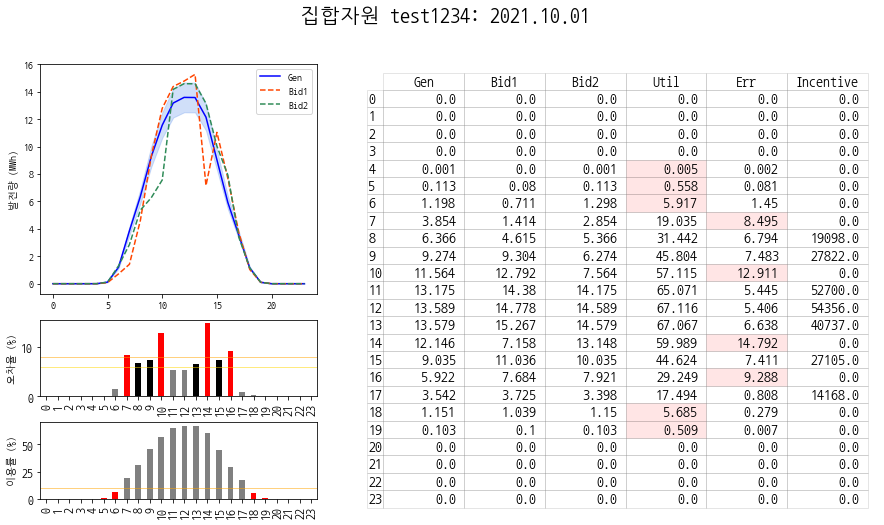

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'NanumGothicCoding'


resourceId = 'test1234'
tradeDate = '2021.10.01'
fig, ax = plt.subplots(3,2, figsize=[15,8], gridspec_kw={'height_ratios': [3, 1, 1], 'width_ratios':[4, 7]})
df.plot(y=['Gen','Bid1','Bid2'], style=['-','--','--'], ax=ax[0,0], ylabel='발전량 (MWh)', color=['blue','orangered','seagreen'])
ax[0,0].fill_between(df.index, 
                 df.Gen*(1+INCENTIVE_LEVEL_2.error/100), 
                 df.Gen*(1-INCENTIVE_LEVEL_2.error/100), color="cornflowerblue", alpha=0.3)

clrs = ['red' if (x > INCENTIVE_LEVEL_2.error) else 'black' if (x > INCENTIVE_LEVEL_1.error) else 'grey' for x in df.Err ]
df.plot.bar(y='Err',ax=ax[1,0], color=clrs, legend=False, ylabel='오차율 (%)', fontsize=12)
clrs = ['red' if (x < UTILIZATION_RATE_THRESHOLD) else 'grey' for x in df.Util ]
df.plot.bar(y='Util',ax=ax[2,0], color=clrs, legend=False, ylabel='이용률 (%)', fontsize=12)

ax[1,0].axhline(y=INCENTIVE_LEVEL_2.error, color='orange', linewidth=0.5)
ax[1,0].axhline(y=INCENTIVE_LEVEL_1.error, color='gold', linewidth=0.5)
ax[2,0].axhline(y=UTILIZATION_RATE_THRESHOLD, color='orange', linewidth=0.5)

gs = ax[0,1].get_gridspec()
for r_ax in ax[:,1]:
    r_ax.remove()
new_ax = fig.add_subplot(gs[:,1])
new_ax.axis('off')

cellc = np.full(df.shape, 'white')
for idx,row in enumerate(cellc):
    if 0<df.at[idx,'Util']<10:
        cellc[idx,3] = 'red'
    if df.at[idx,'Err']>8:
        cellc[idx,4] = 'red'


t = pd.plotting.table(new_ax, df,cellColours=cellc, loc='best')
t.scale(1,1.45)
t.set_fontsize(14)

for cell in t._cells:
    t._cells[cell].set_alpha(.1)

fig.suptitle(f'집합자원 {resourceId}: {tradeDate}', fontsize=20)